In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import sympy as sp

In [2]:
%matplotlib nbagg

In [3]:
mux, stdx = 1, 3
muy, stdy = 4, 4
fx = stats.norm(mux, stdx)
fy = stats.norm(muy, stdy)

In [4]:
def Z(X, Y):
    '''Rezerva spolehlivosti Z=Y+1-X**2'''
    return Y + 1 - X**2

def get_bound_y(x):
    '''Hranice poruchy Z=0'''
    return x**2 - 1

# Monte Carlo

In [5]:
nsim = 1000000 # počet simulací
x = fx.rvs(nsim) # realizace náhodné veličiny X
y = fy.rvs(nsim) # realizace náhodné veličiny Y

z = Z(x,y) # rezerva spolehlivosti

fails = z < 0 # poruchy
nf = np.sum(fails) # počet poruch
pf = nf / float(nsim) # pravděpodobnost poruchy
print('pf =', pf)
print('počet poruch', nf)

pf = 0.53518
počet poruch 535180


<IPython.core.display.Javascript object>


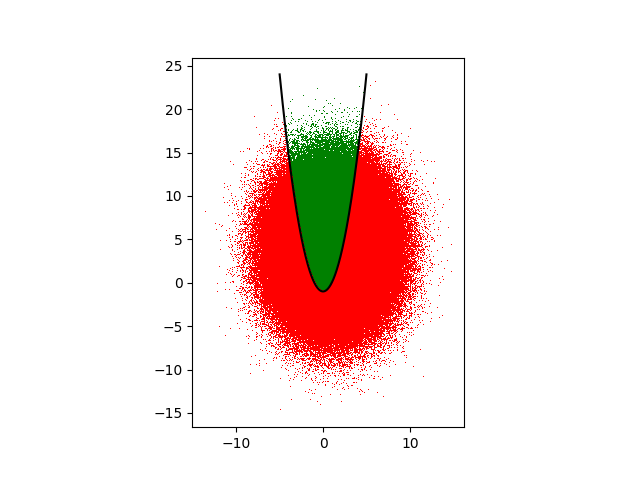

In [6]:
fig, ax = plt.subplots()
ax.plot(x[~fails], y[~fails], 'g,')
ax.plot(x[fails], y[fails], 'r,')
bound_x = np.linspace(-5,5,1000)
ax.plot(bound_x, get_bound_y(bound_x), 'k-')
ax.set_aspect('equal')

# Importance Sampling

In [7]:
hx = stats.norm(mux, stdx * 2)
hy = stats.norm(muy, stdy * 2)

In [8]:
xi = hx.rvs(nsim) # realizace váhové funkce náhodné veličiny X
yi = hy.rvs(nsim) # realizace váhové funkce náhodné veličiny Y

zi = Z(xi,yi) # rezerva spolehlivosti

failsi = zi < 0 # poruchy

weights = (fx.pdf(xi[failsi]) * fy.pdf(yi[failsi]) / (hx.pdf(xi[failsi]) * hy.pdf(yi[failsi]))) # opravné váhy poruch
pfi = np.sum(weights)/float(nsim) # pravděpodobnost poruchy

print('pf =', pfi)
print(u'počet bodů v oblasti porchy', np.sum(failsi))

pf = 0.535886319197
počet bodů v oblasti porchy 748972


<IPython.core.display.Javascript object>


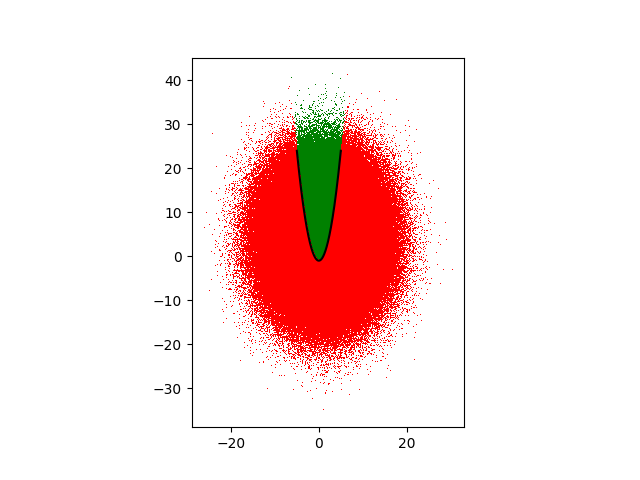

In [9]:
fig, ax = plt.subplots()
ax.plot(xi[~failsi], yi[~failsi], 'g,')
ax.plot(xi[failsi], yi[failsi], 'r,')
bound_x = np.linspace(-5,5,1000)
ax.plot(bound_x, get_bound_y(bound_x), 'k-')
ax.set_aspect('equal')

# FORM
transformace na normální normované rozdělení $\mathcal{N}(0,1)$

$u_x = \dfrac{x - \mu_x}{\sigma_x} \Rightarrow x = u_x  \sigma_x + \mu_x$

$u_y = \dfrac{y - \mu_y}{\sigma_y} \Rightarrow y = u_y  \sigma_y + \mu_y$

$Z = Y + 1 - X^2$

hranice poruchy $Z = 0$:

$u_y = \dfrac{(u_x  \sigma_x + \mu_x)^2 - \mu_y - 1}{\sigma_y}$

In [10]:
def get_bound_uy(ux, mux, stdx, muy, stdy):
    '''Hranice poruchy Z=0'''
    return ((ux * stdx + mux)**2 - muy - 1) / float(stdy)

bound_ux = np.linspace(-2,1.5,1000)
bound_uy = get_bound_uy(bound_ux, mux, stdx, muy, stdy)

In [11]:
dist = np.sqrt(bound_ux ** 2 + bound_uy ** 2) # vzdálenost bodů hranice od počátku [0,0]
beta = dist.min() # minimální vzdálenost
rv = stats.norm(0, 1) # normální normované rozdělení
pf = rv.cdf(-beta) # převod indexu spolehlivosti na pravděpodobnost poruchy
print('beta =', beta)
print('pf =', pf)

beta = 0.394058301284
pf = 0.346768998039


In [12]:
dp_idx = np.where(dist == beta)
dpx = bound_ux[dp_idx] # návrhový bod souřadnice x
dpy = bound_uy[dp_idx] # návrhový bod souřadnice y
print('x =', dpx)
print('y =', dpy)

x = [ 0.37537538]
y = [-0.11989692]


<IPython.core.display.Javascript object>


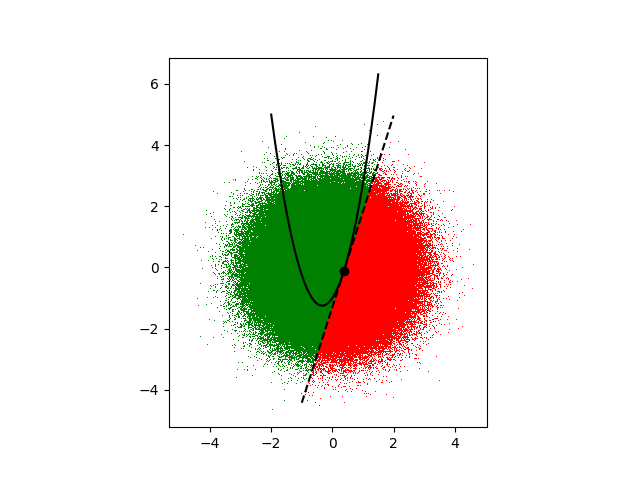

pf = 0.345617 podle MC pod hranici metody FORM


In [13]:
plt.figure()
ux = (x - mux) / float(stdx) # transformace realizací MC do N(0,1)
uy = (y - muy) / float(stdy) # transformace realizací MC do N(0,1)

plt.plot(dpx, dpy, 'ko')
plt.plot([0,dpx], [0,dpy], 'm-', lw=2)

# aproximace hranice poruchy přímkou
for i in range(len(dpx)):
    k0 = -dpx[i]/dpy[i]
    a = (dpy[i]**2 + dpx[i]**2) / dpy[i]
    print('pf =', np.sum(uy < k0 * ux + a) / float(nsim), 'podle MC pod hranici metody FORM')
    ux_plot = np.array([-1,2])
    plt.plot(ux_plot, k0 * ux_plot + a, 'k--', zorder=10)
    plt.gca().set_aspect('equal')

i = len(dpx) - 1
k0 = -dpx[i]/dpy[i]
a = (dpy[i]**2 + dpx[i]**2) / dpy[i]
fails2 = uy < (k0 * ux + a)

plt.plot(ux[~fails2], uy[~fails2], 'g,')
plt.plot(ux[fails2], uy[fails2], 'r,')
plt.plot(dpx, dpy, 'ko')
plt.plot(bound_ux, get_bound_uy(bound_ux, mux, stdx, muy, stdy), 'k-');

## Opentruns

In [14]:
import openturns as ot

# dimension
dim = 2

# Analytical model definition:
limitState = ot.Function(['X', 'Y'], ['G'], ['Y + 1 - X*X'])

# Test of the limit state function:
x = [300., 75000.]
print('x=', x)
print('G(x)=', limitState(x))

x= [300.0, 75000.0]
G(x)= [-14999]


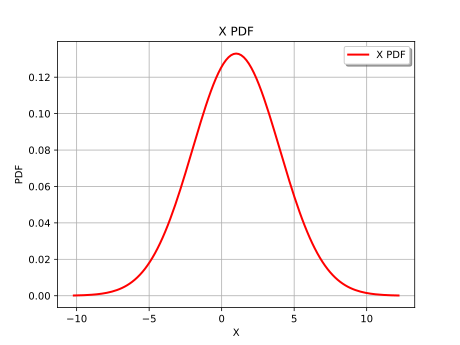

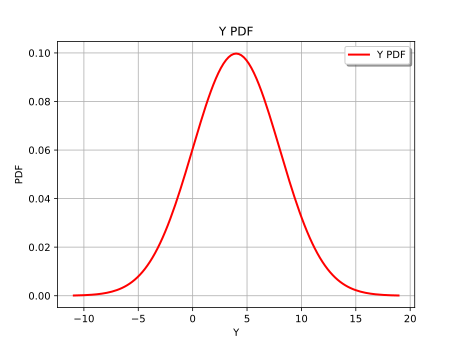

In [15]:
X_dist = ot.Normal(mux, stdx)
X_dist.setName('X')
X_dist.setDescription('X')
# Graphical output of the PDF
display(X_dist.drawPDF())

Y_dist = ot.Normal(muy, stdy)
Y_dist.setName('Y')
Y_dist.setDescription('Y')
# Graphical output of the PDF
Y_dist.drawPDF()

In [16]:
# Create a copula : IndependentCopula (no correlation)
aCopula = ot.IndependentCopula(dim)
aCopula.setName('Independent copula')

# Instanciate one distribution object
myDistribution = ot.ComposedDistribution([X_dist, Y_dist], aCopula)
myDistribution.setName('myDist')

# We create a 'usual' RandomVector from the Distribution
vect = ot.RandomVector(myDistribution)

# We create a composite random vector
G = ot.RandomVector(limitState, vect)

# We create an Event from this RandomVector
myEvent = ot.Event(G, ot.Less(), 0.0)

MonteCarlo result= probabilityEstimate=5.393586e-01 varianceEstimate=7.243466e-04 standard deviation=2.69e-02 coefficient of variation=4.99e-02 confidenceLength(0.95)=1.05e-01 outerSampling=343 blockSize=1
Number of executed iterations = 343
Number of calls to the limit state = 343
Pf =  0.5393586005830908
CV = 0.049899433968349456


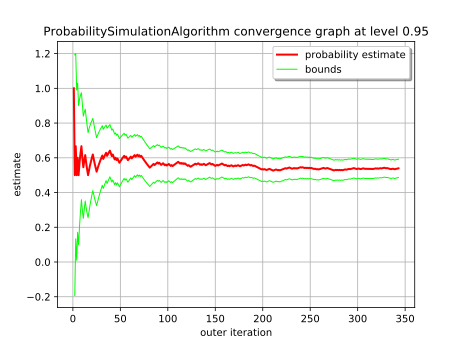

In [17]:
# Using Monte Carlo simulations
cv = 0.05
NbSim = 100000

experiment = ot.MonteCarloExperiment()
algoMC = ot.ProbabilitySimulationAlgorithm(myEvent, experiment)
algoMC.setMaximumOuterSampling(NbSim)
algoMC.setBlockSize(1)
algoMC.setMaximumCoefficientOfVariation(cv)
# For statistics about the algorithm
initialNumberOfCall = limitState.getEvaluationCallsNumber()

# Perform the analysis:
algoMC.run()

# Results:
result = algoMC.getResult()
probability = result.getProbabilityEstimate()
print('MonteCarlo result=', result)
print('Number of executed iterations =', result.getOuterSampling())
print('Number of calls to the limit state =', limitState.getEvaluationCallsNumber() - initialNumberOfCall)
print('Pf = ', probability)
print('CV =', result.getCoefficientOfVariation())
algoMC.drawProbabilityConvergence()

In [18]:
X_dist = ot.Normal(mux, stdx * 2)
X_dist.setName('X')
X_dist.setDescription('X')

Y_dist = ot.Normal(muy, stdy * 2)
Y_dist.setName('Y')
Y_dist.setDescription('Y')

myImportance = ot.ComposedDistribution([X_dist, Y_dist], aCopula)
experiment = ot.ImportanceSamplingExperiment(myImportance)
algo = ot.ProbabilitySimulationAlgorithm(ot.StandardEvent(myEvent), experiment)
algo.setMaximumCoefficientOfVariation(0.05)
algo.setMaximumOuterSampling(1000)
algo.setConvergenceStrategy(ot.Full())
algo.run()

# retrieve results
result = algo.getResult()
probability = result.getProbabilityEstimate()
print('Pf=', probability)

Pf= 0.4737260000392833
